# define the state q by x, y, vx, vy
real transformation:
$ q_t = A_tq_{t-1} + B_ta_{t-1} $

In [1336]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from copy import deepcopy
from scipy.stats.distributions import chi2
from matplotlib.patches import Ellipse


In [1337]:
# 绘制协方差2D椭圆
def plot_covariance_ellipse(ax, mean, cov, confidence_level=0.95, color='black', alpha=0.2, label=None):
    """
    在给定轴上绘制一个2D协方差椭圆。
    参数:
        ax: Matplotlib 的 axes 对象。
        mean: 2D 均值向量 (例如, [x, y])。
        cov: 2x2 协方差矩阵。
        confidence_level: 所需的置信水平 (例如, 0.95 代表 95% 置信)。
        color: 椭圆的颜色。
        alpha: 椭圆的透明度。
        label: 椭圆的标签。
    """
    # 确保协方差矩阵是2x2
    if cov.shape != (2, 2):
        raise ValueError("Covariance matrix must be 2x2 for 2D ellipse plotting.")

    # 计算置信水平对应的卡方分布的临界值
    # 对于 2D 高斯分布，马氏距离平方服从自由度为 2 的卡方分布
    # s 是椭圆半轴的缩放因子
    s = np.sqrt(chi2.ppf(confidence_level, 2))

    # 对协方差矩阵进行特征值分解
    eigenvalues, eigenvectors = np.linalg.eig(cov)

    # 计算椭圆的旋转角度 (以度为单位)
    # arctan2 给出的是弧度，转换为度
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))

    # 计算椭圆的宽度和高度 (半轴长度乘以缩放因子 s)
    width, height = 2 * s * np.sqrt(eigenvalues)

    # 创建椭圆补丁对象
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      facecolor=color, edgecolor=color, alpha=alpha, label=label)
    ax.add_patch(ellipse)
    return ellipse

In [1338]:
def plot_throwing(q, o = None, q_preds = None, sigma_preds = None):
    x = q[:,0]
    y = q[:,1]
    vx = q[:,2]
    vy = q[:,3]

    fig, ax = plt.subplots(figsize=(12, 9))

    ax.plot(x, y, '-', color='g')
    # plt.quiver(x, y, vx, np.zeros_like(vx), angles='xy', scale_units='xy', scale=2, color='g', label='Velocity vectors')
    # plt.quiver(x, y, np.zeros_like(vy), vy, angles='xy', scale_units='xy', scale=2, color='y', label='Velocity vectors')
    # plt.legend()
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('Kalman Filter Trajectory with 95% Confidence Ellipses')
    # ax.legend()
    ax.grid(True)
    ax.set_aspect('equal', adjustable='box') # 保持坐标轴比例一致，避免椭圆变形

    if o is not None:
        ox = o[:, 0]
        oy = o[:, 1]
        ax.scatter(ox, oy, s=15, color='r')
    
    if q_preds is not None:
        xp = q_preds[:,0]
        yp = q_preds[:,1]
        ax.plot(xp, yp, '*--', color='b')

        if sigma_preds is not None:
            for i in range(len(xp)):
                pos_mean = [xp[i], yp[i]]
                pos_cov = sigma_preds[i, :2,:2]

                plot_covariance_ellipse(ax, pos_mean, pos_cov, confidence_level=0.95,
                                    color='green', alpha=0.15) # 使用绿色，半透明

    plt.show()

In [1339]:


delta_t = 0.5
A = np.array([
    [1, 0, delta_t, 0],
    [0, 1, 0, delta_t],
    [0, 0, 1, 0],
    (0, 0, 0, 1)
], dtype=float)

B = np.array([
    [0, 0, 0],
    [0, 0.5*delta_t*delta_t, 0],
    [0, 0, 0],
    [0, delta_t, 0]
], dtype=float)

g = 10

action = np.array([0, -g, 0]).reshape((3,1))

# Simulate Observation, Adding normal distributed noise


In [1340]:
def random_cov(dim, scale=100):
    L = np.tril(np.random.rand(dim, dim))*scale
    cov = L@L.T
    return cov

def build_cov(var:list[float]):
    dim = len(var)
    cov = np.eye(dim)
    np.fill_diagonal(cov, var)
    return cov

cov = build_cov([0.1,0.1])
print(cov)

rand_cov = random_cov(4)
print(rand_cov)

[[0.1 0. ]
 [0.  0.1]]
[[ 9650.29389119  2825.45147934  3125.55807565  2545.37078243]
 [ 2825.45147934  1287.77328282  2437.61580874   855.12382558]
 [ 3125.55807565  2437.61580874 10880.66219331  3013.92020064]
 [ 2545.37078243   855.12382558  3013.92020064  1628.52916942]]


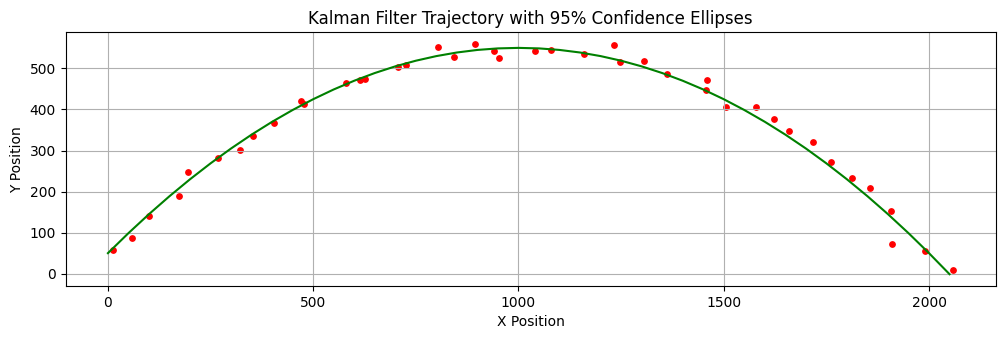

In [1341]:
C = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]]
)
R = random_cov(2, 20)


def simulate_observe(q): 
    return C@q + np.random.multivariate_normal([0,0], R).reshape((2,1))

q0 = np.array([0, 50, 100, 100], dtype=float).reshape((4,1))
q_list = [q0]
o_list = [simulate_observe(q0)]
for t in range(1, int(30*1/delta_t), 1):
    q0 = A @ q0 + B @ action
    q_list.append(q0)
    o = simulate_observe(q0)
    # print(o)
    o_list.append(o)
    if q0[1] < 0:
        break
plot_throwing(np.array(q_list), np.array(o_list))

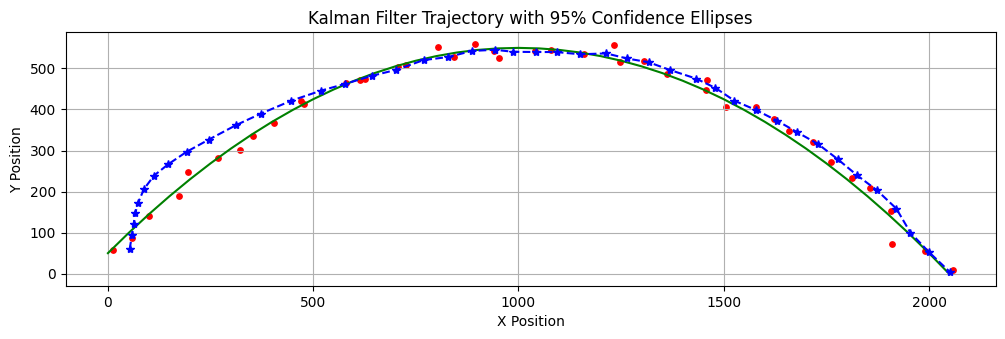

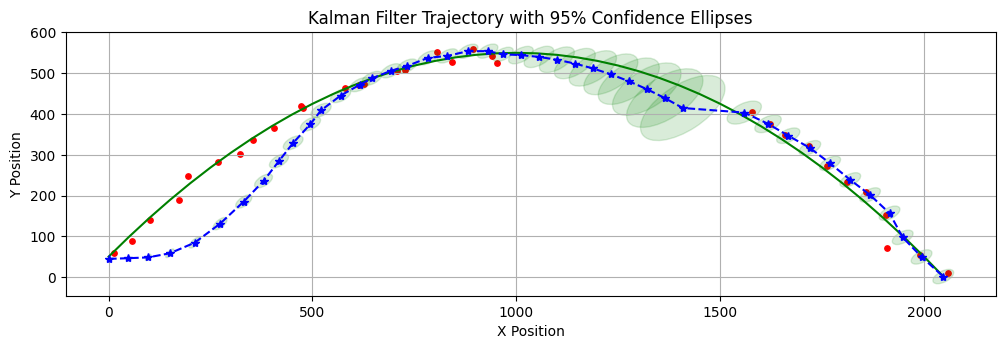

In [1342]:
class KalmanFilter:
    def __init__(self):
        self.mu = np.random.random((4,1))*100
        self.sigma = np.eye(4, dtype=float)

        self.action = action # constant for ball throwing
        # self.Q = build_cov([1000, 1000, 2000, 2000]) # constant for ball throwing
        self.Q = random_cov(4,scale=2)
        self.R = R
        self.C = C

        self.q_preds = [self.mu]
        self.sgm_preds = [self.sigma]
    
    def update(self, observe=None):
        # o = np.array(observe).reshape((2,1))
        # prediction
        mu_ = A@self.mu + B@action
        sigma_ = A@self.sigma@A.T + self.Q
        if observe is None:
            self.mu = mu_
            self.sigma = sigma_
        else:
            # update
            # K = sigma_@self.C.T@np.linalg.inv(self.C@sigma_@self.C.T + self.R)
            K = np.linalg.solve((self.C@sigma_@self.C.T + self.R).T, (sigma_@self.C.T).T ).T
            self.mu = mu_ + K@(observe - self.C@mu_)
            self.sigma = (np.eye(4) - K@self.C)@sigma_

        self.q_preds.append(self.mu)
        self.sgm_preds.append(self.sigma)

kf = KalmanFilter()

for o in o_list:
    kf.update(o)

plot_throwing(np.array(q_list), np.array(o_list), np.array(kf.q_preds))

# o_list[0:5] = [np.ones(shape=(2,1),dtype=float)*100]*5
o_num = len(o_list)
o_list[o_num//2:o_num//2+10] = [None]*10

kf1 = KalmanFilter()
for o in o_list:
    kf1.update(o)
plot_throwing(np.array(q_list), np.array([o for o in o_list if o is not None]), np.array(kf1.q_preds), np.array(kf1.sgm_preds))
